In [1]:
import os
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)
print("Working directory:", os.getcwd())

Working directory: c:\Users\benjo\OneDrive\Data Science Masters\DSMP\dsmp-2024-group-19


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tools import *

code adapted from: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [11]:
data = read_merged_data()
data = pd.DataFrame(data[0])[:600]
dataset = data.dropna(subset=["Last Tapes Price"])


Opening UoB_Set01_2025-01-02tapes.csv


In [12]:

dataset = dataset["Last Tapes Price"].values.reshape(-1,1)

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [13]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

395 195


In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [16]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
393/393 - 6s - loss: 68891.7812 - 6s/epoch - 15ms/step
Epoch 2/100
393/393 - 4s - loss: 68685.7812 - 4s/epoch - 11ms/step
Epoch 3/100
393/393 - 4s - loss: 68480.2812 - 4s/epoch - 11ms/step
Epoch 4/100
393/393 - 4s - loss: 68275.1719 - 4s/epoch - 10ms/step
Epoch 5/100
393/393 - 4s - loss: 68070.4453 - 4s/epoch - 10ms/step
Epoch 6/100
393/393 - 4s - loss: 67866.0391 - 4s/epoch - 11ms/step
Epoch 7/100
393/393 - 4s - loss: 67662.0312 - 4s/epoch - 11ms/step
Epoch 8/100
393/393 - 4s - loss: 67458.4453 - 4s/epoch - 10ms/step
Epoch 9/100
393/393 - 4s - loss: 67255.1484 - 4s/epoch - 11ms/step
Epoch 10/100
393/393 - 4s - loss: 67052.2031 - 4s/epoch - 10ms/step
Epoch 11/100
393/393 - 4s - loss: 66849.5625 - 4s/epoch - 10ms/step
Epoch 12/100
393/393 - 4s - loss: 66647.2812 - 4s/epoch - 10ms/step
Epoch 13/100
393/393 - 4s - loss: 66445.3125 - 4s/epoch - 10ms/step
Epoch 14/100
393/393 - 4s - loss: 66243.6953 - 4s/epoch - 10ms/step
Epoch 15/100
393/393 - 4s - loss: 66042.3281 - 4s/epoch -

In [20]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

 1/13 [=>............................] - ETA: 0s

7/7 [==============================] - 0s 7ms/step


ValueError: Found array with dim 3. None expected <= 2.

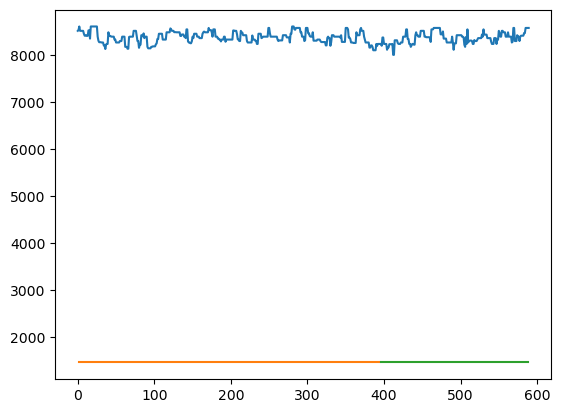

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()